### Imports

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf
import threading

In [2]:
from matplotlib import patheffects as pe
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow import keras

In [3]:
tf.compat.v1.disable_eager_execution()

### Global Parameters

In [9]:
EPOCHS = 5
IMAGE_SIZE = (224, 224)
PKMN_DIRECTORY = 'C:/temp/PokemonData'
PLOT_DIRECTORY = 'Plots'
TEST_SIZE = 1000
TRAIN_SIZE = 6000
CLASS_COUNT = len(os.listdir(PKMN_DIRECTORY + '/Train'))

### Data

#### Data Generator Initialization

In [10]:
# Define ImageDataGenerator with custom augmentation parameters.
image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True, height_shift_range = 0.05, width_shift_range = 0.05,
    zoom_range = 0.2, brightness_range = [0.9, 1.5], rescale = 1./255.)

# Initialize flow from training data directory.
train_flow = image_data_generator.flow_from_directory(PKMN_DIRECTORY + '/Train',
    target_size = IMAGE_SIZE, batch_size = 64)

# Set up flow from test data directory.
test_flow = image_data_generator.flow_from_directory(PKMN_DIRECTORY + '/Test', 
    target_size = IMAGE_SIZE, batch_size = 64)

Found 3421 images belonging to 149 classes.
Found 3358 images belonging to 149 classes.


#### Data Set Generation

In [11]:
def generate_data_set(size, generator):
    """
    Accept a keras ImageDataGenerator flow and use it to generate X and Y numpy 
    arrays of a specified size.
    
    Args:
        size: The amount of images and labels to generate.
        generator: ImageDataGenerator flow.
    Returns:
        X: "size" images from generator.
        Y: "size" labels from generator.
    """
    # Initialize loop variables.
    X = []
    Y = []

    while len(X) < size:
        next_images, next_labels = test_flow.next()
        X.extend(next_images)
        Y.extend(next_labels)

    # Cut off any extra unwanted images.
    X = X[:size]
    Y = Y[:size]

    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [12]:
X_train, Y_train = generate_data_set(TRAIN_SIZE, train_flow)
X_test, Y_test = generate_data_set(TEST_SIZE, test_flow)

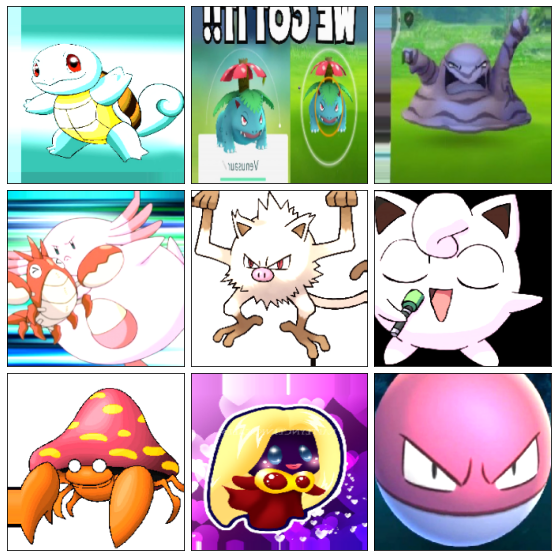

In [13]:
# Initialize plot.
fig = plt.figure(1, (10, 10))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad = 0.1)

for ax, image in zip(grid, X_test):
    # Reverse normalization to get full pixel values.
    image = np.array(image * 255).astype('uint8')
    # Show image in grid cell.
    ax.imshow(image)
    # Remove ticks from around image.
    ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
        labelbottom = False, labelleft = False)

fig.savefig(PLOT_DIRECTORY + '/data_example.jpg', bbox_inches = 'tight')

### Scratch-Built Model

#### Model Structure

In [14]:
# Initialize model.
scratch_model = keras.models.Sequential()
# Convolutional Layers
scratch_model.add(keras.layers.Conv2D(16, (3, 3), activation = 'relu', 
    input_shape = (*IMAGE_SIZE, 3)))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
# Dense Layers
scratch_model.add(keras.layers.Flatten())

scratch_model.add(keras.layers.Dense(128, activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))

scratch_model.add(keras.layers.Dense(128, activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
# Output Layer
scratch_model.add(keras.layers.Dense(CLASS_COUNT, activation = 'softmax'))

In [15]:
scratch_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-04),
    loss = keras.losses.CategoricalCrossentropy(), 
    metrics = [keras.metrics.CategoricalAccuracy()])

In [16]:
scratch_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

#### Training

In [17]:
# Define callbacks
checkpoint = keras.callbacks.ModelCheckpoint('models/scratch_model_best', 
    monitor = 'val_categorical_accuracy', mode = 'min', save_freq = 'epoch',
    save_best_only = True, save_weights_only = False)
plateau_handling = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_categorical_accuracy', patience = 5, factor = 0.1)

scratch_model_history = scratch_model.fit(X_train, Y_train, epochs = EPOCHS,
    validation_data = (X_test, Y_test),
    callbacks = [checkpoint, plateau_handling])

Train on 6000 samples, validate on 1000 samples
Epoch 1/5
6000/6000 [==============================] - ETA: 0s - loss: 4.9669 - categorical_accuracy: 0.0122

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: models\scratch_model_best\assets
6000/6000 [==============================] - 46s 8ms/sample - loss: 4.9669 - categorical_accuracy: 0.0122 - val_loss: 4.8563 - val_categorical_accuracy: 0.0230 - lr: 1.0000e-04
Epoch 2/5
6000/6000 [==============================] - 33s 6ms/sample - loss: 4.6501 - categorical_accuracy: 0.0320 - val_loss: 4.5023 - val_categorical_accuracy: 0.0670 - lr: 1.0000e-04
Epoch 3/5
6000/6000 [==============================] - 33s 5ms/sample - loss: 4.2164 - categorical_accuracy: 0.0782 - val_loss: 4.0861 - val_categorical_accuracy: 0.1230 - lr: 1.0000e-04
Epoch 4/5
6000/6000 [==============================] - 33s 5ms/sample - loss: 3.8319 - categorical_accuracy: 0.1322 - val_loss: 3.7096 - val_categorical_accuracy: 0.1920 - lr: 1.0000e-04
Epoch 5/5
6000/6000 [==============================] - 33s 5ms/sample - loss: 3.4861 - categorical_accuracy: 0.1852 - val_loss: 3.4507 - val_categorical_accuracy: 0.2160 - lr: 1.0000e-04


#### Results

In [31]:
def print_training_stats(history):
    """
    Print the maximum and minimum of every training metric in a keras training
    history.
    
    Args:
        history: Return value of a keras model's fit method.
    """
    for metric in history.history.keys():
        met_max = max(history.history[metric])
        met_min = min(history.history[metric])
        
        print(('{}' + ('_' * (30 - len(metric)))  + '\n'\
               '     Max: {:.5f}'  + '\n'\
               '     Min: {:.5f}').format(metric, met_max, met_min))

In [19]:
def plot_training_history(history, metric = 'loss', save_name = None):
    """
    Plot training and validation metrics over epochs.
    
    Args:
        history: Return value of a keras model's fit method.
        metric: All lowercase name of the metric you wish to plot.
         - default: 'loss'
        save_name: Name to save the generated plot under (including file ext).
        If no name is provided the plot will not be saved.
         - default: None
    """
    # Initialize plot.
    fig = plt.figure(2, (7, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    # Initialize empty list to save each line for the legend.
    lines = []
    # Grab relevant history elements.
    
    epochs = history.params['epochs']
    metric_history = np.array(history.history[metric])
    val_metric_history = np.array(history.history['val_' + metric])
    # Find which epoch the minimum validation loss was reached.
    min_val_metric_bool_idx = val_metric_history == min(val_metric_history)
    min_val_metric_x = np.arange(epochs)[min_val_metric_bool_idx] + 1
    
    # Plot Content
    lines.append(ax.plot(np.arange(epochs) + 1, metric_history))
    lines.append(ax.plot(np.arange(epochs) + 1, val_metric_history))
    ax.scatter(min_val_metric_x, min(val_metric_history), color = 'green', 
        zorder = 3)

    # Limits
    ax.set_xlim(1, epochs)

    # Labels
    ax.set_title('Loss Over Epochs (Lower Is Better)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.title())
    txt = ax.text(min_val_metric_x - 0.05, min(val_metric_history) + 0.2, 
        'Lowest Validation Loss - {:.2f}'.format(min(val_metric_history)), 
        ha = 'right')
    txt.set_path_effects([pe.withStroke(linewidth = 7, foreground = 'w')])

    # Legend
    ax.legend(labels = ['Training Loss', 'Validation Loss']);
    
    if save_name != None:
        fig.savefig(PLOT_DIRECTORY + '/' + save_name)

In [32]:
print_training_stats(scratch_model_history)

loss__________________________
     Max: 4.96692
     Min: 3.48608
categorical_accuracy__________
     Max: 0.18517
     Min: 0.01217
val_loss______________________
     Max: 4.85632
     Min: 3.45069
val_categorical_accuracy______
     Max: 0.21600
     Min: 0.02300
lr____________________________
     Max: 0.00010
     Min: 0.00010


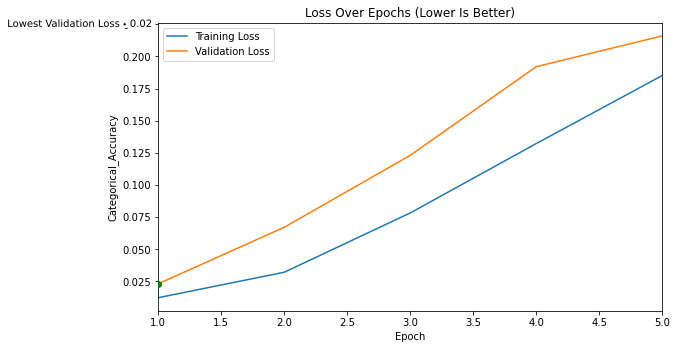

In [21]:
plot_training_history(scratch_model_history, 'categorical_accuracy',
    save_name = 'scratch_model_loss.jpg')

In [28]:
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

NameError: name 'pickle' is not defined

In [33]:
# Release memory.

keras.backend.clear_session()
gc.collect()

3615

### Transfer Learning

In [16]:
def build_model(application, output_count = 2, input_shape = (*IMAGE_SIZE, 3), 
    dense_count = 128, learning_rate = 1e-04, l2_factor = 1e-05,
    dropout_rate = 0.1):
    '''
    Build a 2D convolutional neural network for transfer learning using a base
    keras application. 

    Args:
        application: Keras application to use as base model.
        output_count: Amount of classes in the model's output.
         - default: 2
        input_shape: Shape of the image data the network will be predicting on.
         - default: (224, 224, 3)
        dense_count: Amount of neurons in the dense layer between the last
        convolutional layer and the output layer.
         - default: 128
        learning_rate: Learning rate for Adam optimizer.
         - default: 1e-5
        l2_factor: Factor for l2 regularizer.
         - default: 1e-2
         dropout_rate: The dropout rate of the last intermediate dense layer.
          - default: 0.2

    Returns:
        model: Convolutional neural network made using provided specifications.
    '''
    # Model property shotrcuts.
    l2 = keras.regularizers.l2(l2_factor)
    adam = keras.optimizers.Adam(learning_rate)
    # Initalize application.
    base_model = application(weights = 'imagenet', include_top = False,
        input_shape = input_shape)
    base_model.trainable = False
    # Initialize model.
    model = keras.models.Sequential()
    # Base
    model.add(base_model)
    # Dense layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(dense_count, activation = 'relu', 
        kernel_regularizer = l2, bias_regularizer = l2, 
        activity_regularizer = l2))
    model.add(keras.layers.Dropout(dropout_rate))
    # Output layer
    model.add(keras.layers.Dense(output_count, activation = 'softmax'))
    model.compile(optimizer = adam, loss = 'categorical_crossentropy',
        metrics = [keras.metrics.CategoricalAccuracy()])

    print(model.summary())

    return model

#### VGG16

In [17]:
vgg16_model = build_model(keras.applications.VGG16, output_count = CLASS_COUNT)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 149)               19221     
Total params: 17,945,301
Trainable params: 3,230,613
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [18]:
# Define callbacks
checkpoint = keras.callbacks.ModelCheckpoint('models/vgg16_model_best', 
    monitor = 'val_accuracy', mode = 'min', save_freq = 'epoch',
    save_best_only = True, save_weights_only = False)
plateau_handling = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
    patience = 5, factor = 0.1)

vgg16_model_history = vgg16_model.fit(train_flow, epochs = EPOCHS, 
    validation_data = (X_test, Y_test),
    callbacks = [checkpoint, plateau_handling])

Epoch 1/100
54/54 [==============================] - ETA: 0s - batch: 26.5000 - size: 63.3519 - loss: 4.9818 - categorical_accuracy: 0.0117

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


54/54 [==============================] - 71s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 4.9818 - categorical_accuracy: 0.0117 - val_loss: 4.8623 - val_categorical_accuracy: 0.0300 - lr: 1.0000e-04
Epoch 2/100
54/54 [==============================] - 52s 967ms/step - batch: 26.5000 - size: 63.3519 - loss: 4.7299 - categorical_accuracy: 0.0585 - val_loss: 4.6375 - val_categorical_accuracy: 0.0670 - lr: 1.0000e-04
Epoch 3/100
54/54 [==============================] - 56s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 4.4152 - categorical_accuracy: 0.1178 - val_loss: 4.3161 - val_categorical_accuracy: 0.1450 - lr: 1.0000e-04
Epoch 4/100
54/54 [==============================] - 56s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 4.0528 - categorical_accuracy: 0.2020 - val_loss: 4.0266 - val_categorical_accuracy: 0.2080 - lr: 1.0000e-04
Epoch 5/100
54/54 [==============================] - 56s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 3.7132 - categorical_accuracy: 0.2812 - val

In [19]:
print_training_stats(vgg16_model_history)

Max Accuracy: 0.79
Min Loss:     0.97


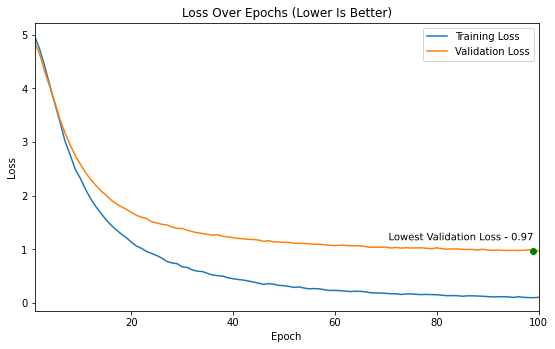

In [41]:
plot_training_history(vgg16_model_history, save_name = 'vgg16_model_loss.jpg')

#### Xception

In [21]:
xception_model = build_model(keras.applications.Xception,
    output_count = CLASS_COUNT)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 149)               19221     
Total params: 33,725,885
Trainable params: 12,864,405
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [22]:
# Define callbacks
checkpoint = keras.callbacks.ModelCheckpoint('models/xception_model_best', 
    monitor = 'val_accuracy', mode = 'min', save_freq = 'epoch',
    save_best_only = True, save_weights_only = False)
plateau_handling = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
    patience = 5, factor = 0.1)

xception_model_history = xception_model.fit(train_flow, epochs = EPOCHS, 
    validation_data = (X_test, Y_test),
    callbacks = [checkpoint, plateau_handling])

Epoch 1/100
54/54 [==============================] - ETA: 0s - batch: 26.5000 - size: 63.3519 - loss: 4.8323 - categorical_accuracy: 0.0348

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


54/54 [==============================] - 65s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 4.8323 - categorical_accuracy: 0.0348 - val_loss: 4.4940 - val_categorical_accuracy: 0.0890 - lr: 1.0000e-04
Epoch 2/100
54/54 [==============================] - 55s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 4.1412 - categorical_accuracy: 0.1429 - val_loss: 3.9671 - val_categorical_accuracy: 0.2170 - lr: 1.0000e-04
Epoch 3/100
54/54 [==============================] - 57s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 3.5467 - categorical_accuracy: 0.2581 - val_loss: 3.5648 - val_categorical_accuracy: 0.2770 - lr: 1.0000e-04
Epoch 4/100
54/54 [==============================] - 56s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 2.9688 - categorical_accuracy: 0.3742 - val_loss: 3.2075 - val_categorical_accuracy: 0.3440 - lr: 1.0000e-04
Epoch 5/100
54/54 [==============================] - 57s 1s/step - batch: 26.5000 - size: 63.3519 - loss: 2.5405 - categorical_accuracy: 0.4648 - val_lo

In [23]:
print_training_stats(xception_model_history)

Max Accuracy: 0.68
Min Loss:     1.51


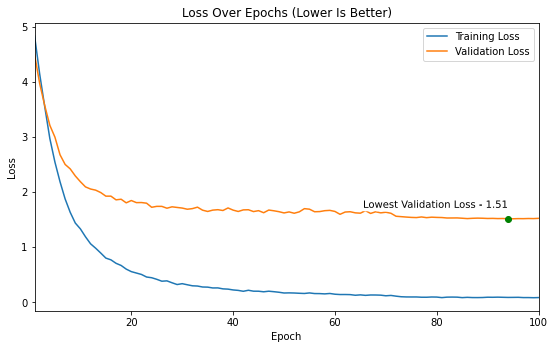

In [42]:
plot_training_history(xception_model_history,
    save_name = 'xception_model_loss.jpg')

### Who's That Pokémon?! Model Showdown

In [25]:
scratch_model.load_weights('Models/scratch_model_best')
vgg16_model.load_weights('Models/vgg16_model_best')
xception_model.load_weights('Models/xception_model_best')

In [26]:
def load_images(path, target_size = None):
    """
    Load all images from selected path.
    
    Args:
        path: Directory from which to load all images.
        target_size: size which all images should be resized to. If none is
        provided all images remain their original size.
         - default: None
    Returns:
        images: List of every image in the target directory as numpy arrays.
    """
    # Initialize images list.
    images = []
    
    for image_name in os.listdir(path):
        # Get image from specified path.
        image = PIL.Image.open(path + '/' + image_name)
        # Optionally resize image.
        if target_size != None:
            image = image.resize(target_size)
        
        image = np.array(image)
        
        images.append(image)
    
    return images
        

In [27]:
# Grab images for the who's that pokemon.
colors = load_images(PKMN_DIRECTORY + '/Sprites Color', 
    target_size = IMAGE_SIZE)
silhouettes = load_images(PKMN_DIRECTORY + '/Sprites Silhouette', 
    target_size = IMAGE_SIZE)

In [28]:
def get_prediction(model, image):
    """
    Predict on an image using the provided model and find the name of the
    pokemon which correspondes to that prediction.
    
    Args:
        model: The model used to predict on the provided image. Output of the
        model must match the amount of classes in the training data directory.
        image: The image that the provided model should predict on.
    """
    # Get the names of every pokemon from the train data directory.
    pokemon_names = np.array(os.listdir(PKMN_DIRECTORY + '/Train'))
    # Make image compatible with input shape of model.
    model_input = np.array([image])
    
    pred = model.predict(model_input)[0]
    # Use the position of the highest value in the prediction to select a name.
    bool_pred = [pred == max(pred)]
    pred_pokemon_name = pokemon_names[bool_pred][0]
    
    return pred_pokemon_name
    

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\linkw\AppData\Local\Temp/ipykernel_35992/1452042679.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred_pokemon_name = pokemon_names[bool_pred][0]


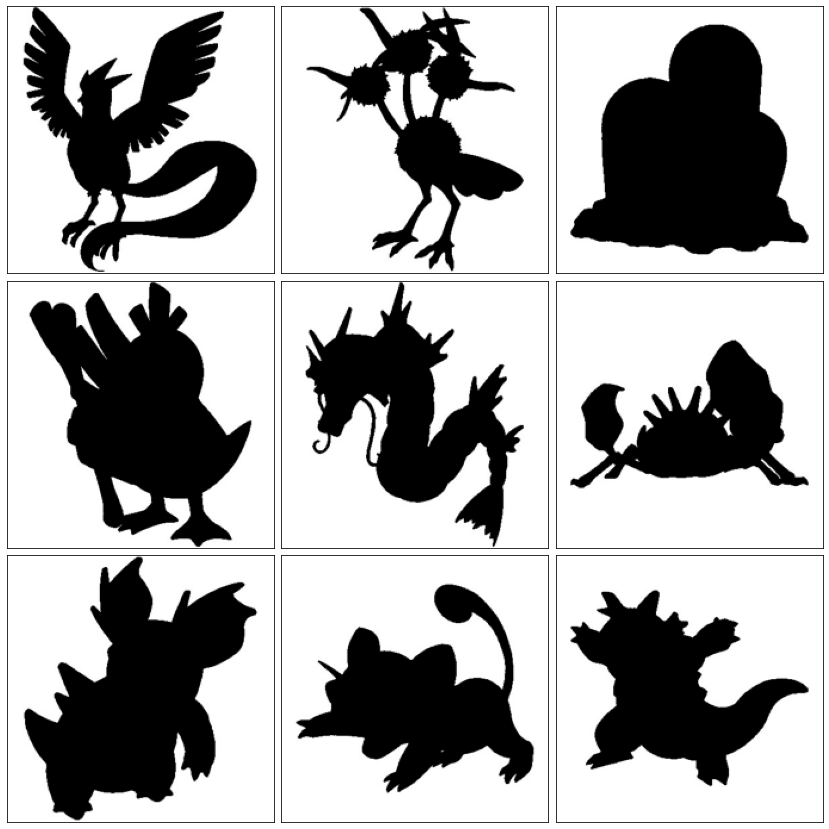

In [29]:
# Initialize plot.
fig = plt.figure(1, (15, 15))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad = 0.1)

predictions = []

for ax, image in zip(grid, silhouettes):
    # Show image in grid cell.
    ax.imshow(image)
    # Remove ticks from around image.
    ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
        labelbottom = False, labelleft = False)
    # Get predictions from each model.
    normalized_image = image.astype('float') / 255
    models = [scratch_model, vgg16_model, xception_model]
    prediction = [get_prediction(model,  normalized_image) for model in models]
    # Record predictions from each model.
    pred_template = 'Scratch Model: {}\nVGG16: {}\nXception: {}'
    predictions.append(pred_template.format(*prediction))

fig.savefig(PLOT_DIRECTORY + '/Silhouettes.jpg', bbox_inches = 'tight')

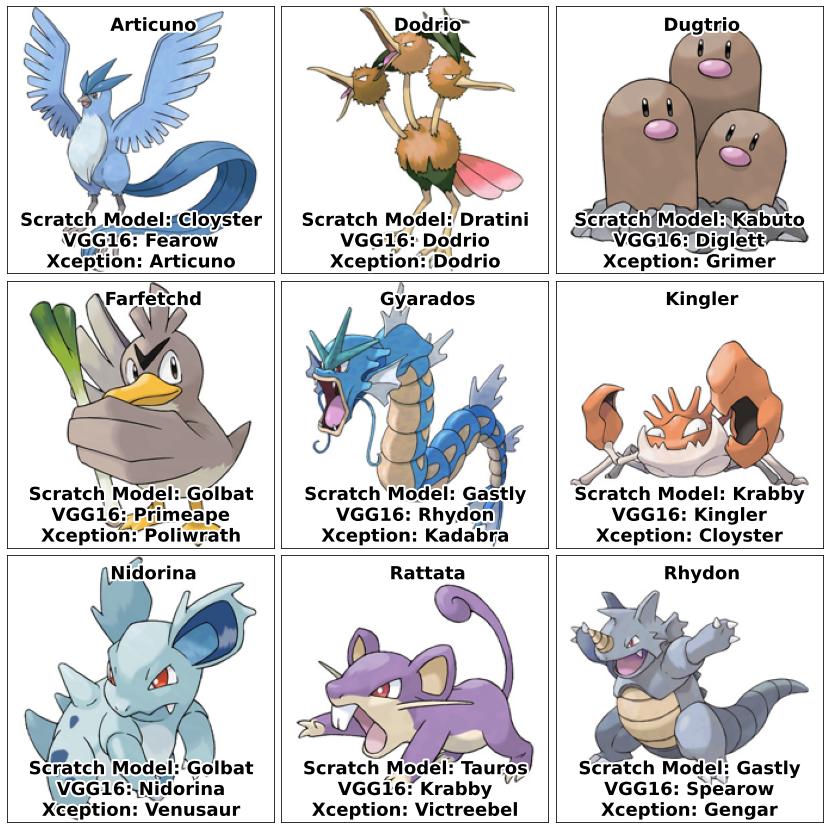

In [30]:
# Initialize plot.
fig = plt.figure(1, (15, 15))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad = 0.1)

for ax, prediction, image, image_name in zip(grid, predictions, colors,
    os.listdir(PKMN_DIRECTORY + '/Sprites Color')):
    # Show image in grid cell.
    ax.imshow(image)
    # Remove ticks from around image.
    ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
        labelbottom = False, labelleft = False)
    # Attach pokemon name to image.
    pkmn_name = ax.text(122, 20, image_name[:-4], ha = 'center', 
        fontdict = {'fontsize': 18, 'fontweight': 1000})
    pkmn_name.set_path_effects([pe.withStroke(linewidth = 4, foreground = 'w')])
    # Attach predictions to image.
    title = ax.set_title(prediction, y = 0, loc = 'center',
        fontdict = {'fontsize': 18, 'fontweight': 1000})
    title.set_path_effects([pe.withStroke(linewidth = 4, foreground = 'w')])
    
fig.savefig(PLOT_DIRECTORY + '/Results.jpg', bbox_inches = 'tight')